In [1]:
%pip install matplotlib pandas seaborn scikit-learn dtale seaborn xgboost


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


- ## 0 **Import de librerias a utilizar**

In [2]:
import sys
import os
sys.path.append(os.path.abspath("./src"))

import dtale
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import xgboost as xgb


from utils import fraud_licit_ratio, calcular_nulos, split_by_suffix, nan_ratio, visualize_missing_values, missing_audit
from pipelines import split_features , reduce_dataset_complexity_pipeline, logistic_pipeline, svm_pipeline, xgboost_pipeline_reduced, xgboost_pipeline_raw

from sklearn.metrics import roc_auc_score, average_precision_score, f1_score


from evaluate import evaluate_multiple


- ### 0.1 Import de Datasets

In [3]:
df_train_transaction = pd.read_csv('./dataset/train_transaction.csv')
df_train_identity = pd.read_csv('./dataset/train_identity.csv')

df_train_transaction.set_index('TransactionID', inplace=True)
df_train_identity.set_index('TransactionID', inplace=True)

- ## 1 **Preparacion inicial de los datasets**

> Nuestros datasets esta dividido en dos partes, uno tiene mucha informacion de identidad y otro la data de la transaccion. No todas las transacciones tienen su correspondiente en el Dataset Identity asi que hacemos un merge outer para mantener todos los datos en un dataset grande.

> Utilizamos una herramienta para analisis EDA rapido para visualizar y navegar un dataset que tiene mas de 400 columnas.

In [4]:
df_full_transaction = pd.merge(
    df_train_transaction,
    df_train_identity,
    on="TransactionID",
    how="outer"
)

print("Shape merged Outer:", df_full_transaction.shape)
# dtale.show(df_full_transaction)

Shape merged Outer: (590540, 433)


In [5]:
calcular_nulos(df_full_transaction)
fraud_licit_ratio(df_full_transaction)

Cantidad de valores nulos en isFraud: 0

Distribución de isFraud:
Clase 0: 569877 registros (96.50%)
Clase 1: 20663 registros (3.50%)


In [6]:
nan_ratio(df_train_transaction, 'Transanciones')

nan_ratio(df_train_identity, 'Entidades')

Top 10 columns with highest NaN ratio in Transanciones:
dist2    0.936284
D7       0.934099
D13      0.895093
D14      0.894695
D12      0.890410
D6       0.876068
D8       0.873123
D9       0.873123
V153     0.861237
V139     0.861237
dtype: float64

Columns with >50% NaN in Transanciones: ['dist2', 'D7', 'D13', 'D14', 'D12', 'D6', 'D8', 'D9', 'V153', 'V139', 'V162', 'V161', 'V154', 'V138', 'V158', 'V157', 'V163', 'V156', 'V155', 'V149', 'V148', 'V147', 'V146', 'V142', 'V141', 'V140', 'V151', 'V152', 'V145', 'V144', 'V150', 'V143', 'V160', 'V166', 'V164', 'V159', 'V165', 'V322', 'V332', 'V338', 'V337', 'V336', 'V335', 'V334', 'V333', 'V331', 'V323', 'V330', 'V328', 'V327', 'V326', 'V325', 'V324', 'V329', 'V339', 'V240', 'V235', 'V252', 'V249', 'V248', 'V247', 'V246', 'V244', 'V243', 'V242', 'V241', 'V237', 'V236', 'V233', 'V254', 'V232', 'V231', 'V230', 'V229', 'V228', 'V217', 'V226', 'V225', 'V224', 'V223', 'V218', 'V253', 'V219', 'V266', 'V262', 'V268', 'V267', 'V273', 'V274', 'V275

> En nuestra evaluacion vemos que el Dataset luego de unidos los datos de transacciones y de identidades, tienen muchos datos NaN, nuestro aproach inicial fue de reducir las columnas con alto nive de % NaN y luego limpiar las filas. Esto nos dejaba con un dataset 40% aproximadamente mas chico y nos preocupaba que nuestro modelo se viera afectado en la prediccion por esto.

> Decidimos tomar el camina de auditar las columnas con un metodo denominado `lift missing values` que nos permite determinar la viabilidad de eliminar una columna evaluando que tanto impacto tiene en nuestro target. Si es cercana a 1 la variable podria se elminada, si es mayor o menor el valor NaN o la presencia de la columna con valor no NaN podria darnos pista de un fraude y ser valiosa.  

In [7]:
result, drop_candidates = missing_audit(df_full_transaction, 'isFraud')
print(result)
print("Columnas candidatas a eliminar:", drop_candidates)

       col  pct_missing  fraud_rate_if_missing  fraud_rate_if_present  \
415  id_24     0.991962               0.034587               0.084685   
416  id_25     0.991310               0.034584               0.081255   
398  id_07     0.991271               0.034570               0.082638   
399  id_08     0.991271               0.034570               0.082638   
412  id_21     0.991264               0.034571               0.082574   
..     ...          ...                    ...                    ...   
24     C10     0.000000                    NaN                    NaN   
25     C11     0.000000                    NaN                    NaN   
26     C12     0.000000                    NaN                    NaN   
27     C13     0.000000                    NaN                    NaN   
28     C14     0.000000                    NaN                    NaN   

     lift_missing  
415      0.408423  
416      0.425629  
398      0.418334  
399      0.418334  
412      0.418662  
.. 

- ## 2 Feature engineering y data cleaning

> Realizando analisis e intentos de entrenamiento de modelos, nos encontramos con que nuestro dataset siendo tan grander rompia o no funcionaba correctamente en especial con modelos como el Logistic Regression y SVM. Viendo estas dificultades pero queriendo comparar contra XGBoost para el analisis de posibles Fraudes, mejoramos un pipeline para modificar nuestras variables numericas y categoricas, a nuestras numericas se le hara una Imputacion simple para los valores vacios manteniendo la mediana, reduciremos las columnas que no difieran mucho para cada muestra y aplicaremos un StandarScaler.

> Nuestras categoricas se les realiza una Imputacion para rellenar los datos vacios con los mas frecuentes y codificamos las variables binarias con OneHot pero para las columnas con muchas opciones usamos un parametro para agrupar las categorias menos frecuentes en una sola cuando tengamos mas de 50 categorias.

In [8]:
y = df_full_transaction['isFraud']
X = df_full_transaction.reset_index(drop=True).drop("isFraud", axis=1)

cat_cols, num_cols = split_features(X)
print(f"Categorical columns: {len(cat_cols)}")
print(f"Numerical columns: {len(num_cols)}")

Categorical columns: 31
Numerical columns: 401


In [9]:
pipeline_reduces = reduce_dataset_complexity_pipeline(X)

In [10]:
pipeline_reduces.fit(X,y)

,steps,"[('preprocess', ...), ('feature_sel', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat_low', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [11]:
X_reduced = pipeline_reduces.transform(X)
print("Shape después de reducción:", X_reduced.shape)

Shape después de reducción: (590540, 82)


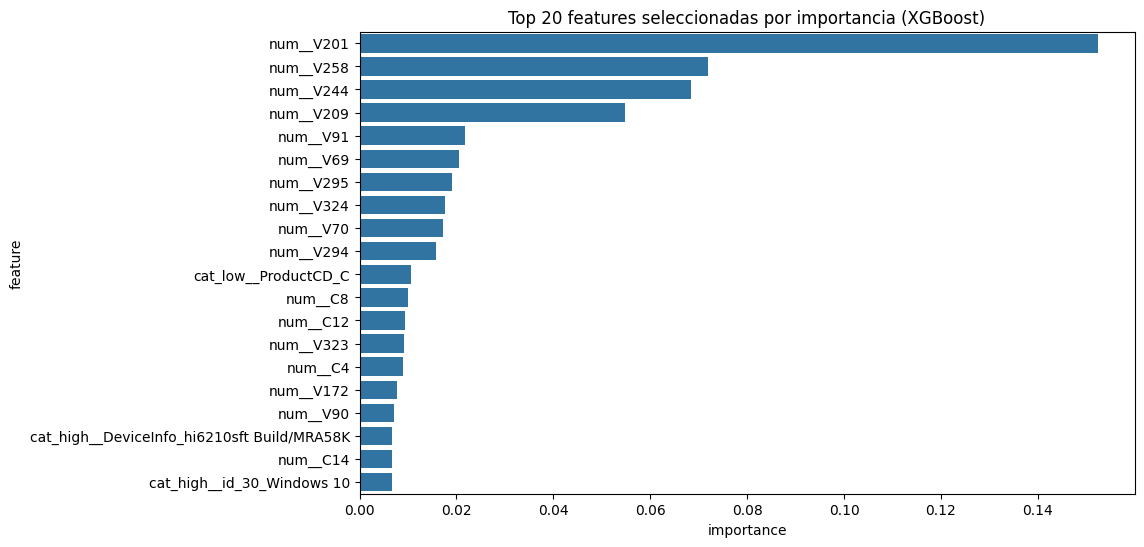

In [14]:
# Importancias del selector (XGBoost)
model = pipeline_reduces.named_steps["feature_sel"].estimator_
importances = model.feature_importances_

feat_names = pipeline_reduces.named_steps["preprocess"].get_feature_names_out()
mask = pipeline_reduces.named_steps["feature_sel"].get_support()
selected_feats = feat_names[mask]

# DataFrame con importancias
df_imp = pd.DataFrame({
    "feature": selected_feats,
    "importance": importances[mask]
}).sort_values("importance", ascending=False)

# Top 20
plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=df_imp.head(20))
plt.title("Top 20 features seleccionadas por importancia (XGBoost)")
plt.show()

> Vemos de esta manera que nuestro pipeline redujo la complejidad de nuestro dataset manteniendo un buen nivel de muestras. Eso si nuestra mejora de modelo aprovecha una parte de el XGBoost para seleccionar las Columnas. XGBoost lo utilizaremos con nuestro dataset crudo y reducido aprovechando su manejo de variables nulas para evaluar que tanta precision se pierde y como se compara con los otros modelos.

- ## 3 Preparacion de Variables para entrenamiento de Modelos 

> Nuetra intencion es realizar un entrenamiento de modelos para
- Regresion Logistica
- SVM
- XGBoost

> Para esto necesitamos que nuestro dataset este preparado para cada uno de nuestros modelos. Nuestra preparacion como mencionamos estara dentro de nuestros Pipelines, los preparamos y definimos asi al momento de entrenarlos vemos los procesos realizados.

In [12]:
log_pipe= logistic_pipeline(df_full_transaction)
svm_pipe= svm_pipeline(df_full_transaction)
xgb_red_pipe= xgboost_pipeline_reduced(df_full_transaction)
xgb_raw_pipe= xgboost_pipeline_raw()

- ## 4 Entrenamiento de Modelos

> Entrenamos nuestros modelos.

In [15]:
log_pipe.fit(X, y)

/Users/jorgesanchez/Documents/learning/UTN/TP-Grupo-S-Fraud-Detection/tpfinal/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



,steps,"[('reduce', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('preprocess', ...), ('feature_sel', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat_low', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3


In [16]:
svm_pipe.fit(X, y)

,steps,"[('reduce', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('preprocess', ...), ('feature_sel', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat_low', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3


In [17]:
xgb_red_pipe.fit(X, y)

,steps,"[('reduce', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('preprocess', ...), ('feature_sel', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat_low', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3


In [18]:
X_raw = X.copy()

for col in X_raw.select_dtypes(include="object").columns:
    X_raw[col] = X_raw[col].astype("category")

xgb_raw_pipe.fit(X_raw, y)

,steps,"[('model', ...)]"
,transform_input,None
,memory,Memory(locati...he_dir/joblib)
,verbose,False
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [33]:
results = {}

In [34]:
y_pred_logreg = log_pipe.predict(X_test)
y_proba_logreg = log_pipe.predict_proba(X_test)[:, 1]

results['Logistic Regression'] = {
    'ROC-AUC': roc_auc_score(y_test, y_proba_logreg),
    'PR-AUC': average_precision_score(y_test, y_proba_logreg),
    'F1': f1_score(y_test, y_pred_logreg)
}
print("\n=== Logistic Regression ===")
print(f"ROC-AUC: {results['Logistic Regression']['ROC-AUC']:.4f}")
print(f"PR-AUC:  {results['Logistic Regression']['PR-AUC']:.4f}")
print(f"F1:      {results['Logistic Regression']['F1']:.4f}")


=== Logistic Regression ===
ROC-AUC: 0.8422
PR-AUC:  0.3768
F1:      0.2156


In [35]:
y_pred_svm = svm_pipe.predict(X_test)
y_proba_svm = svm_pipe.predict_proba(X_test)[:, 1]

results['SVM'] = {
    'ROC-AUC': roc_auc_score(y_test, y_proba_svm),
    'PR-AUC': average_precision_score(y_test, y_proba_svm),
    'F1': f1_score(y_test, y_pred_svm)
}

print("\n=== SVM ===")
print(f"ROC-AUC: {results['SVM']['ROC-AUC']:.4f}")
print(f"PR-AUC:  {results['SVM']['PR-AUC']:.4f}")
print(f"F1:      {results['SVM']['F1']:.4f}")


=== SVM ===
ROC-AUC: 0.8392
PR-AUC:  0.3637
F1:      0.0000


In [36]:
y_pred_xgb_red = xgb_red_pipe.predict(X_test)
y_proba_xgb_red = xgb_red_pipe.predict_proba(X_test)[:, 1]


results['XGB_RED'] = {
    'ROC-AUC': roc_auc_score(y_test, y_proba_xgb_red),
    'PR-AUC': average_precision_score(y_test, y_proba_xgb_red),
    'F1': f1_score(y_test, y_pred_xgb_red)
}

print("\n=== XGB_RED ===")
print(f"ROC-AUC: {results['XGB_RED']['ROC-AUC']:.4f}")
print(f"PR-AUC:  {results['XGB_RED']['PR-AUC']:.4f}")
print(f"F1:      {results['XGB_RED']['F1']:.4f}")


=== XGB_RED ===
ROC-AUC: 0.9290
PR-AUC:  0.6967
F1:      0.6259


In [37]:
y_pred_xgb_raw = xgb_raw_pipe.predict(X_test_raw)
y_proba_xgb_raw = xgb_raw_pipe.predict_proba(X_test_raw)[:, 1]

results['XGB_RAW'] = {
    'ROC-AUC': roc_auc_score(y_test_raw, y_proba_xgb_raw),
    'PR-AUC': average_precision_score(y_test_raw, y_proba_xgb_raw),
    'F1': f1_score(y_test_raw, y_pred_xgb_raw)
}

print("\n=== XGB_RAW ===")
print(f"ROC-AUC: {results['XGB_RAW']['ROC-AUC']:.4f}")
print(f"PR-AUC:  {results['XGB_RAW']['PR-AUC']:.4f}")
print(f"F1:      {results['XGB_RAW']['F1']:.4f}")


=== XGB_RAW ===
ROC-AUC: 0.9533
PR-AUC:  0.7778
F1:      0.6773


                      ROC-AUC    PR-AUC        F1
Logistic Regression  0.842159  0.376834  0.215646
SVM                  0.839151  0.363699  0.000000
XGB_RED              0.928988  0.696747  0.625883
XGB_RAW              0.953343  0.777841  0.677278


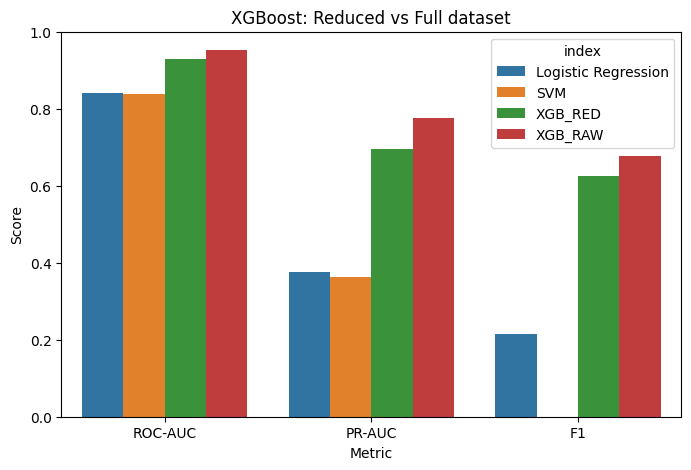

In [ ]:
df_results = pd.DataFrame(results).T
print(df_results)

# === Gráfico comparativo ===
df_plot = df_results.reset_index().melt(id_vars="index", var_name="Metric", value_name="Score")
plt.figure(figsize=(8,5))
sns.barplot(data=df_plot, x="Metric", y="Score", hue="index")
plt.title("XGBoost: Reduced vs Full dataset")
plt.ylabel("Score")
plt.show()